<a href="https://colab.research.google.com/github/trodrigue1304/Fraud_detection_algorithm/blob/Med/source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet de Python** : Détection de fraude bancaire à l'aide d'algorithmes de Machine Learning


## Introduction et présentation du projet

**Introduction**

**Source des données**

**Intérêt et objectifs du projet**

## Initialisation de l'environnement de travail

Etant donné la complexité du projet et le format particulier mais novateur des données utilisées, des méthodes de ML appliquées aux données volumineuses ont été utilisées. De ce fait, des packages supplémentaires ont dû être installé. Il s'agit en particulier de :


*   **impyute** : pour l'imputation de données manquantes par la méthode ***MICE***
*   **dask** : pour l'utilisation de calculs distribués
*   **dask-ml** : pour exécuter les algorithmes de machines learning sur données distribuées
*   Élément de liste



In [1]:
!pip install impyute
!pip install dask
!pip install dask-ml
!pip install distributed

     |████████████████████████████████| 143kB 8.5MB/s 
     |████████████████████████████████| 675kB 9.4MB/s 
     |████████████████████████████████| 6.8MB 18.7MB/s 
     |████████████████████████████████| 92kB 8.2MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=11d58d42a9957db392f7a83957037e8ec13b9bbb28e5a770d4c035cd6609e20e
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4041 sha256=4a79ef67e7cb2e9fffbe5265e0ec180e83c7bc5ece3b37cdd09c1ad8f3db6384
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built contextvars locket
ERROR: distributed 2020.12.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2020.12.0 has requiremen

Viens ensuite la phase de chargement de tous les packages nécessaires.

In [5]:
# Chargement des packages
import os
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import sklearn as skl
import seaborn as sns
import time
import joblib
import warnings
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from dask.distributed import Client
#from dask_ml.linear_model import LogisticRegression as dd_LogisticRegression
from google.colab import drive
from sklearn.impute import KNNImputer
from dask.distributed import Client

On charge l'ensemble des bases de données à partir de Google Drive. C'est une solution satisfaisante étant donné qu'elle permet non seulement un travail collaboratif beaucoup plus précis mais aussi une liaison aux données beaucoup plus aisée dû à l'utilisation de Google Colab.

In [6]:
# Connexion à google drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#On fait un petit test pour comparer les temps d'importation des bases par pandas et dask
%time test_time = pd.read_csv('/content/drive/My Drive/projet python/train_identity.csv') 

CPU times: user 579 ms, sys: 59.3 ms, total: 638 ms
Wall time: 679 ms


In [9]:
%time test_time = dd.read_csv('/content/drive/My Drive/projet python/train_identity.csv') 
del test_time

CPU times: user 28.3 ms, sys: 5.39 ms, total: 33.7 ms
Wall time: 50.1 ms


On voit clairement que les temps d'importation sont plus de 10 fois moins longs. De ce fait, **dask** est une altenative efficace pour le travail avec ces bases de données. Toutefois, pour tout ce qui est statistiques descriptives et préprocessing, pandas le gère très bien. De ce fait, nous n'emploierons les versions dask des données que pour la partie modélisation.

In [10]:
# Importation des données
id_train=pd.read_csv('/content/drive/My Drive/projet python/train_identity.csv')
tr_train=pd.read_csv('/content/drive/My Drive/projet python/train_transaction.csv')
id_test=pd.read_csv('/content/drive/My Drive/projet python/test_identity.csv')
tr_test=pd.read_csv('/content/drive/My Drive/projet python/test_transaction.csv')

In [11]:
## Affichage de plus de lignes pour les output
pd.options.display.max_rows = 500

## On lance un client local pour les calculs distribués
client = Client()

On lance un client local afin de pouvoir utiliser les syntaxes basiques de traitement de données. Il suffira de faire appel à ligne de commande : *with parallel_backend('dask')*
Cette méthode est satisfisante car elle assure non seulement la facile maintenance du code mais aussi la compréhension par des utilisateurs externes de Python.

## Exploration des données

**Visualisation des données**

In [12]:
id_train.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [13]:
tr_train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,mail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,61.0,30.0,318.0,30.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,495.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#verifier que toutes les TransactionID de id_train existe dans tr_train
print("Taille de la base identity : ",id_train.shape)
print("Taille de la base transaction : ",tr_train.shape)
print("Nombre de transactions uniques de la base transaction : ",id_train['TransactionID'].nunique())
print("Nombre de transactions uniques de la base identity : ",tr_train['TransactionID'].nunique())
print("Proportion de transactions avec id information (train): "+"{:.2%}".format(np.sum(tr_train['TransactionID'].isin(id_train['TransactionID'].unique()))/tr_train['TransactionID'].nunique()))
print("Proportion de transactions avec id information (test): "+"{:.2%}".format(np.sum(tr_test['TransactionID'].isin(id_test['TransactionID'].unique()))/tr_test['TransactionID'].nunique()))

Taille de la base identity :  (144233, 41)
Taille de la base transaction :  (590540, 394)
Nombre de transactions uniques de la base transaction :  144233
Nombre de transactions uniques de la base identity :  590540
Proportion de transactions avec id information (train): 24.42%
Proportion de transactions avec id information (test): 28.01%


On remarque qu'il y a des transactions sans informations d'identification. On ne tiendra pas compte de ces données.

**Fusion des bases de données**

In [15]:
train=pd.merge(tr_train,id_train,on="TransactionID",how="right")
test=pd.merge(tr_test,id_test,on="TransactionID",how="right")

**Type des variables**

In [16]:
train.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8          

### **Statistiques descriptives sur les données**

In [ ]:
#Dimension de la base de donnée 
train.shape

* **IsFraud**

In [ ]:
#Repartition des transactions frauduleuses dans la base principale
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

bars = ax.bar(x=np.arange(tab.size),height=tab['TransactionID'],tick_label=['Non Frauduleux', 'Frauduleux'])

* **TransactionAmt**

In [ ]:
#Apercu générale sur la variable
print(train['TransactionAmt'].describe())

plt.figure(figsize=(20,6))

#Distribution de la variable
plt.subplot(1,3,1)
sns.distplot(train.TransactionAmt,bins=30,label='TransactionAmt')
plt.title('TransactionAmt')

#Distribution de la variable suivant le caractère frauduleux 
plt.subplot(1,3,2)
sns.distplot(train[train['isFraud']==1].TransactionAmt,bins=30,kde_kws={"color": "r"},label='TransactionAmt_Fraude')
sns.distplot(train[train['isFraud']==0].TransactionAmt,bins=30,kde_kws={"color": "b"},label='TransactionAmt_Nofraude')
plt.title('TransactionAmt vs Fraude')

plt.subplot(1,3,3)
sns.boxplot(x='isFraud', y='TransactionAmt',data=train,palette='dark')
plt.title('TransactionAmt vs isFraud')
plt.show()


* **Les features Cardi**

In [ ]:
for i in (1,2,3,5):
  varc='card'+str(i)
  #Apercu générale sur la variable
  print(train[varc].describe())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,3,1)
  sns.distplot(train[varc],bins=30)
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,3,2)
  sns.distplot(train[train['isFraud']==1][varc],bins=30,kde_kws={"color": "r"},label=varc+'Fraude')
  sns.distplot(train[train['isFraud']==0][varc],bins=30,kde_kws={"color": "b"},label=varc+'Nofraude')
  plt.title(varc +' vs isFraud')

  plt.subplot(1,3,3)
  sns.boxplot(x='isFraud', y=varc,data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()



* **Les features Ci**

In [ ]:
for i in range(14):
  varc='C'+str(i+1)
  #Apercu générale sur la variable
  print(train[varc].describe())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,3,1)
  sns.distplot(train[varc],bins=30)
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,3,2)
  sns.distplot(train[train['isFraud']==1][varc],bins=30,kde_kws={"color": "r"},label=varc+'Fraude')
  sns.distplot(train[train['isFraud']==0][varc],bins=30,kde_kws={"color": "b"},label=varc+'Nofraude')
  plt.title(varc +' vs isFraud')

  plt.subplot(1,3,3)
  sns.boxplot(x='isFraud', y=varc,data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()


* **Feature D1**

In [ ]:
for i in range(1):
  varc='D'+str(i+1)
  #Apercu générale sur la variable
  print(train[varc].describe())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,3,1)
  sns.distplot(train[varc],bins=30)
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,3,2)
  sns.distplot(train[train['isFraud']==1][varc],bins=30,kde_kws={"color": "r"},label=varc+'Fraude')
  sns.distplot(train[train['isFraud']==0][varc],bins=30,kde_kws={"color": "b"},label=varc+'Nofraude')
  plt.title(varc +' vs isFraud')

  plt.subplot(1,3,3)
  sns.boxplot(x='isFraud', y=varc,data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()


* **Features Vi**

In [ ]:
for i in range(20):
  varc='V'+str(i+95)
  #Apercu générale sur la variable
  print(train[varc].describe())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,3,1)
  sns.distplot(train[varc],bins=30)
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,3,2)
  sns.distplot(train[train['isFraud']==1][varc],bins=30,kde_kws={"color": "r"},label=varc+'Fraude')
  sns.distplot(train[train['isFraud']==0][varc],bins=30,kde_kws={"color": "b"},label=varc+'Nofraude')
  plt.title(varc +' vs isFraud')

  plt.subplot(1,3,3)
  sns.boxplot(x='isFraud', y=varc,data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()


* **Card4**

In [ ]:
varc='card4'
#Apercu générale sur la variable
print(train[varc].value_counts())

plt.figure(figsize=(20,6))

#Distribution de la variable
plt.subplot(1,2,1)
train[varc].value_counts(normalize=True).plot(kind='pie')
plt.title(varc)

#Distribution de la variable suivant le caractère frauduleux 
plt.subplot(1,2,2)
sns.barplot(x=varc,y='TransactionAmt',hue='isFraud',data=train,palette='dark')
plt.title(varc+' vs isFraud')
plt.show()



* **ProbuctCD**

In [ ]:
varc='ProductCD'
#Apercu générale sur la variable
print(train[varc].value_counts())

plt.figure(figsize=(20,6))

#Distribution de la variable
plt.subplot(1,2,1)
train[varc].value_counts(normalize=True).plot(kind='pie')
plt.title(varc)

#Distribution de la variable suivant le caractère frauduleux 
plt.subplot(1,2,2)
sns.barplot(x=varc,y='TransactionAmt',hue='isFraud',data=train,palette='dark')
plt.title(varc+' vs isFraud')
plt.show()

* **Features id quantitatif**

In [ ]:
for i in (12,15,16,28,29,35,36,37,38):
  varc='id_'+str(i)
  #Apercu générale sur la variable
  print(train[varc].value_counts())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,2,1)
  train[varc].value_counts(normalize=True).plot(kind='pie')
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,2,2)
  sns.barplot(x=varc,y='TransactionAmt',hue='isFraud',data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()



On constate de facon générales que les features presentes des valeurs abérrantes. Pour eviter que ces dernières impactes négativements nos modèles, nous allons procéder à une detection de ces valeurs abérrantes puis nous allons les traiter comme des valeurs manquantes de notre base de données.

## Pré-traitement des données

### **Détection des valeurs manquantes**

In [17]:
missing_data=train.isnull().sum().sum()
total_data=np.product(train.shape)
print("Proportion de données manquantes dans la base : "+"{:.2%}".format(missing_data/total_data))

Proportion de données manquantes dans la base : 26.89%


In [18]:
#Fonction pour la visualition de la répartition des données manquantes
def missing_view(data) :
  null_counts = data.isnull().sum()/len(data)
  plt.figure(figsize=(100,20))
  plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
  plt.ylabel('Proportion de données manquantes')
  plt.bar(np.arange(len(null_counts)),null_counts)


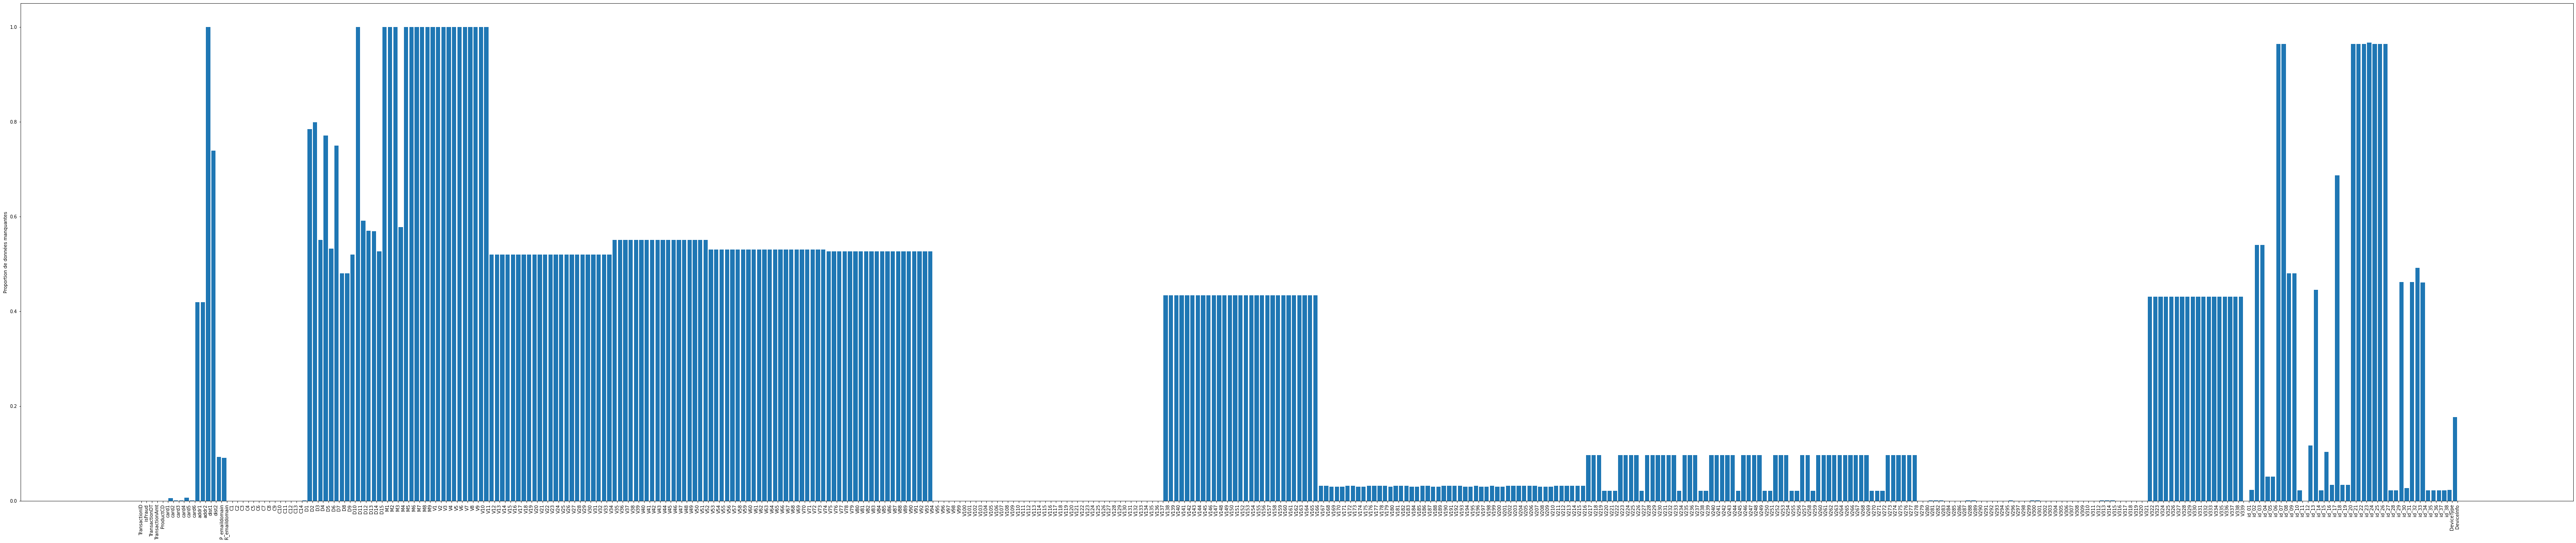

In [19]:
#Visualisation
missing_view(train)

Il faudra donc procéder à un traitement des valeurs manquantes et s'il le faut voir l'impact sur les modèles futurs.

### **Analyse de la variable d'intérêt**

In [20]:
#Tableau des effectifs
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab

,TransactionID
isFraud,
0,132915
1,11318


Text(0.5, 1.0, 'Distribution de la variable isFraud')

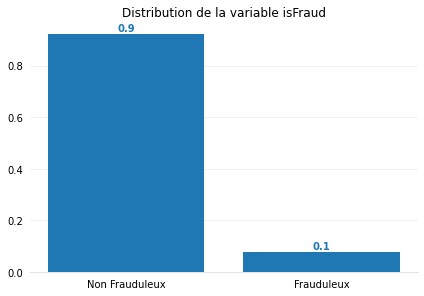

In [21]:
#Visualisation
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.01,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

fig.tight_layout()

ax.set_title("Distribution de la variable isFraud")

  On soupçonne un surapprentissage des modèles sur les valeurs non frauduleuses. On recalibre les données de manière à avoir une répartition uniforme.

In [22]:
#Recalibrage
class0=np.where(train['isFraud']==0)[0]
class1=np.where(train['isFraud']==1)[0]
class0_downsample=np.random.choice(class0,size=len(class1),replace=False)
Kept_index=sorted([*class0_downsample,*class1])
train_calibrate=train[train.index.isin(Kept_index)]

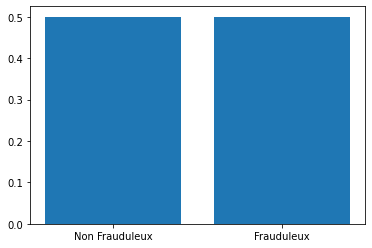

In [23]:
#On s'assure que le tirage a été bien fait
tab = pd.DataFrame(train_calibrate.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

### **Visualisation des données manquantes dans la base recalibré**

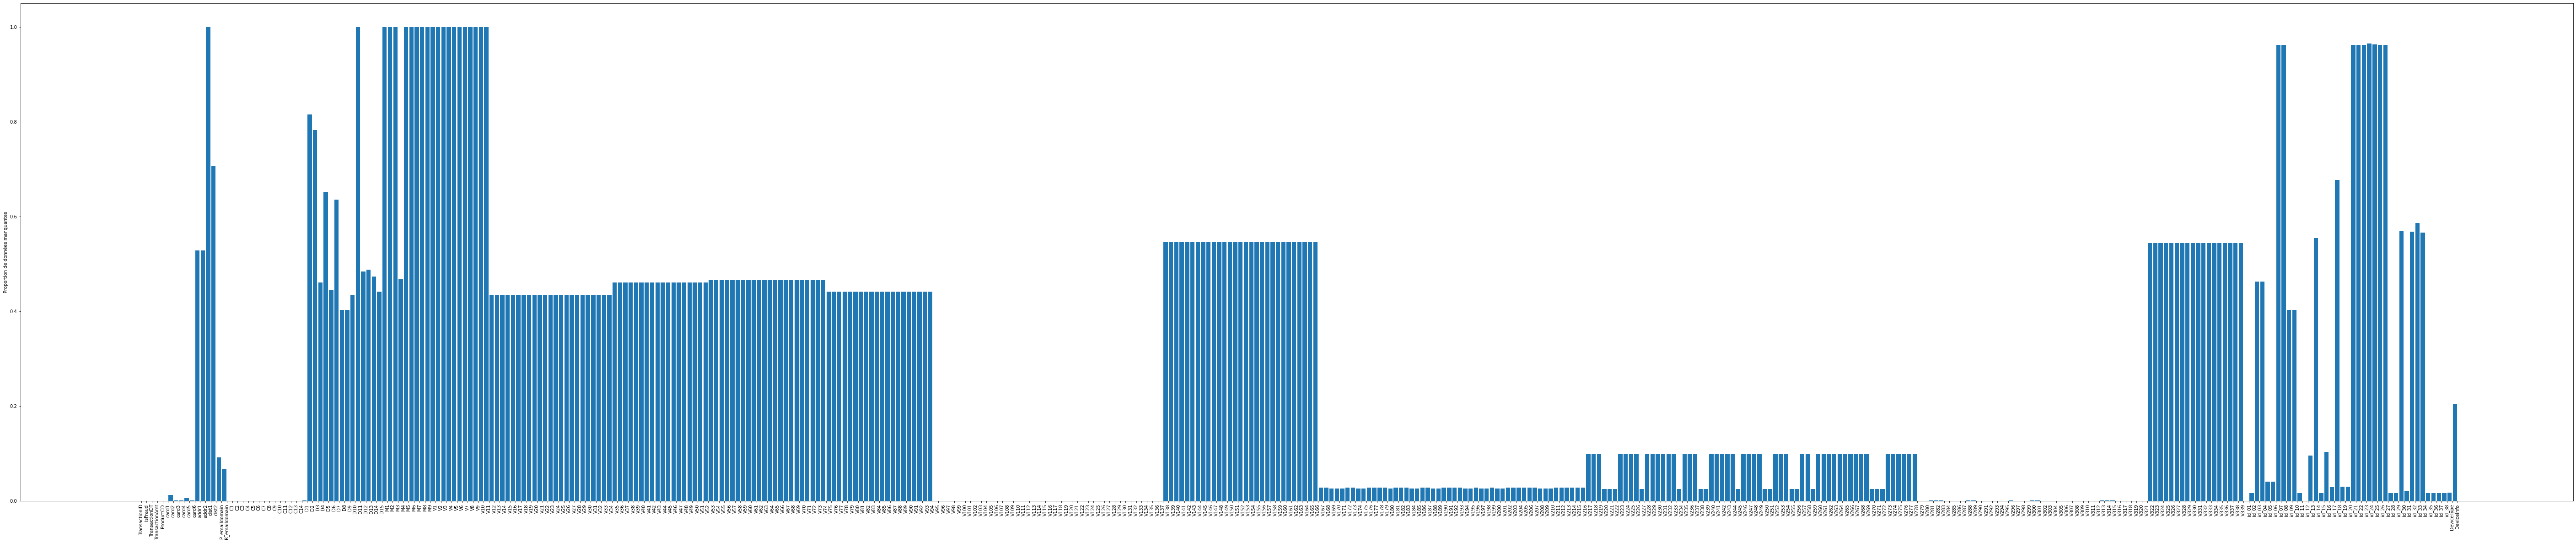

In [24]:
missing_view(train_calibrate)

On remarque que la distribution est quasiment la même avec celle obtenue avant. 
Conclusion : Les données recalibrées sont à l'image des données initiale sur ce plan. On peut donc se restreindre à la nouvelle base pour la suite des travaux.

### **Analyse et traitement des données manquantes**

**Valeurs manquantes suivant la variable d'intérêt**

Text(0.5, 0.98, 'Valeurs manquantes sur les données frauduleuses')

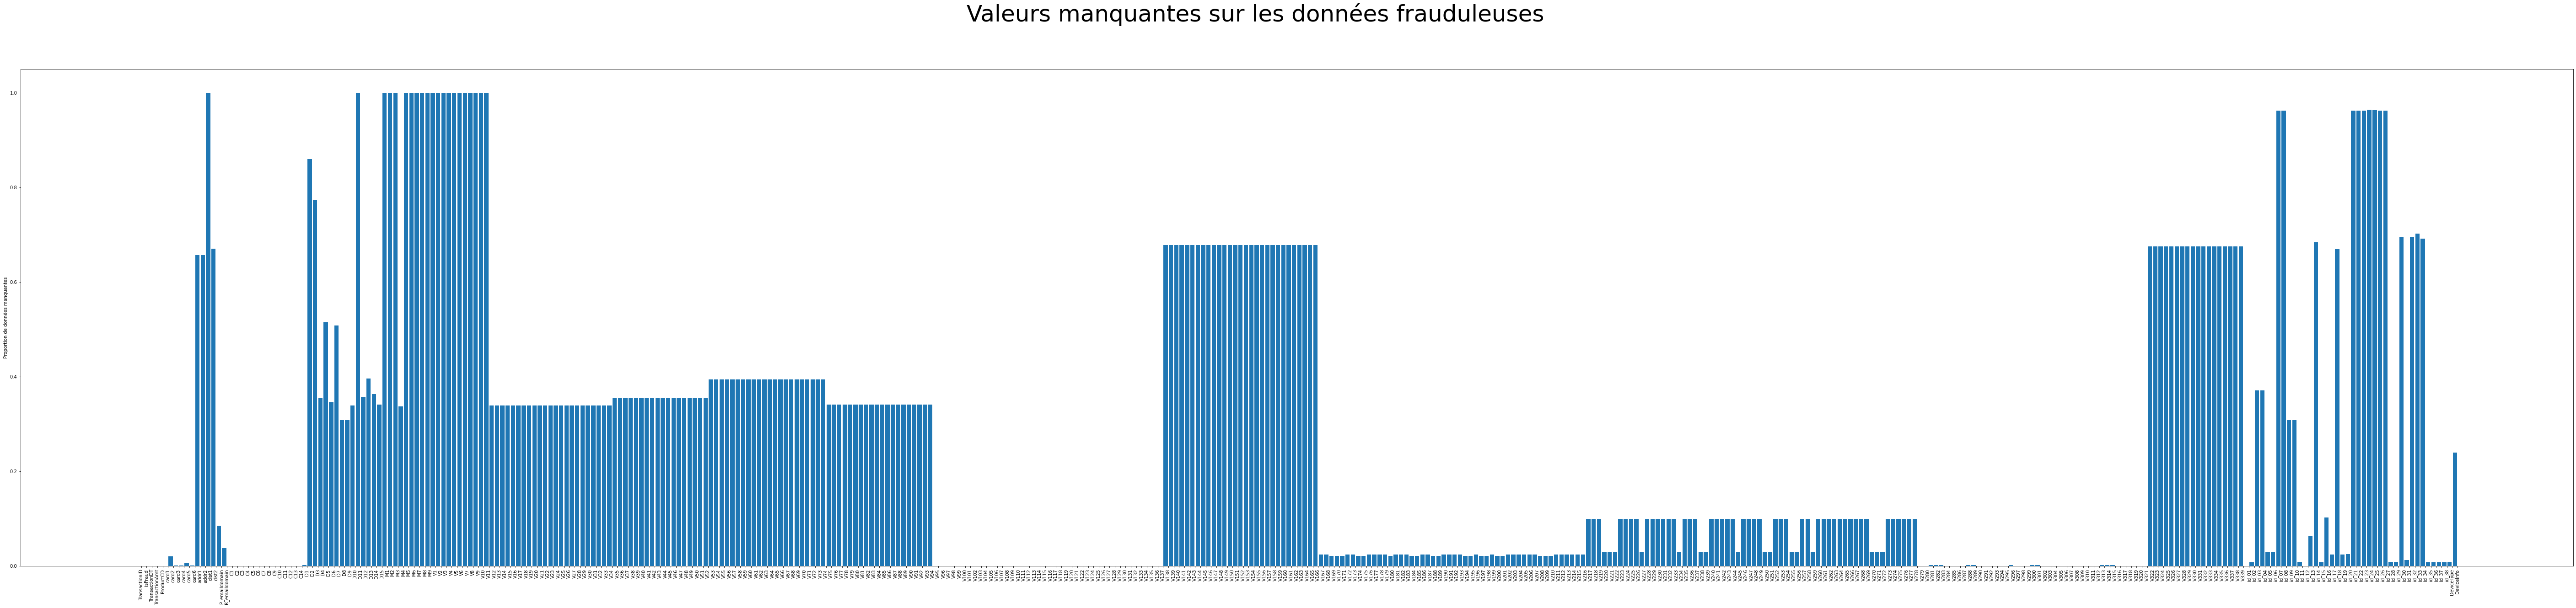

In [25]:
missing_view(train_calibrate[train_calibrate.isFraud == 1])
plt.suptitle("Valeurs manquantes sur les données frauduleuses", fontsize=50)

Text(0.5, 0.98, 'Valeurs manquantes sur les données non frauduleuses')

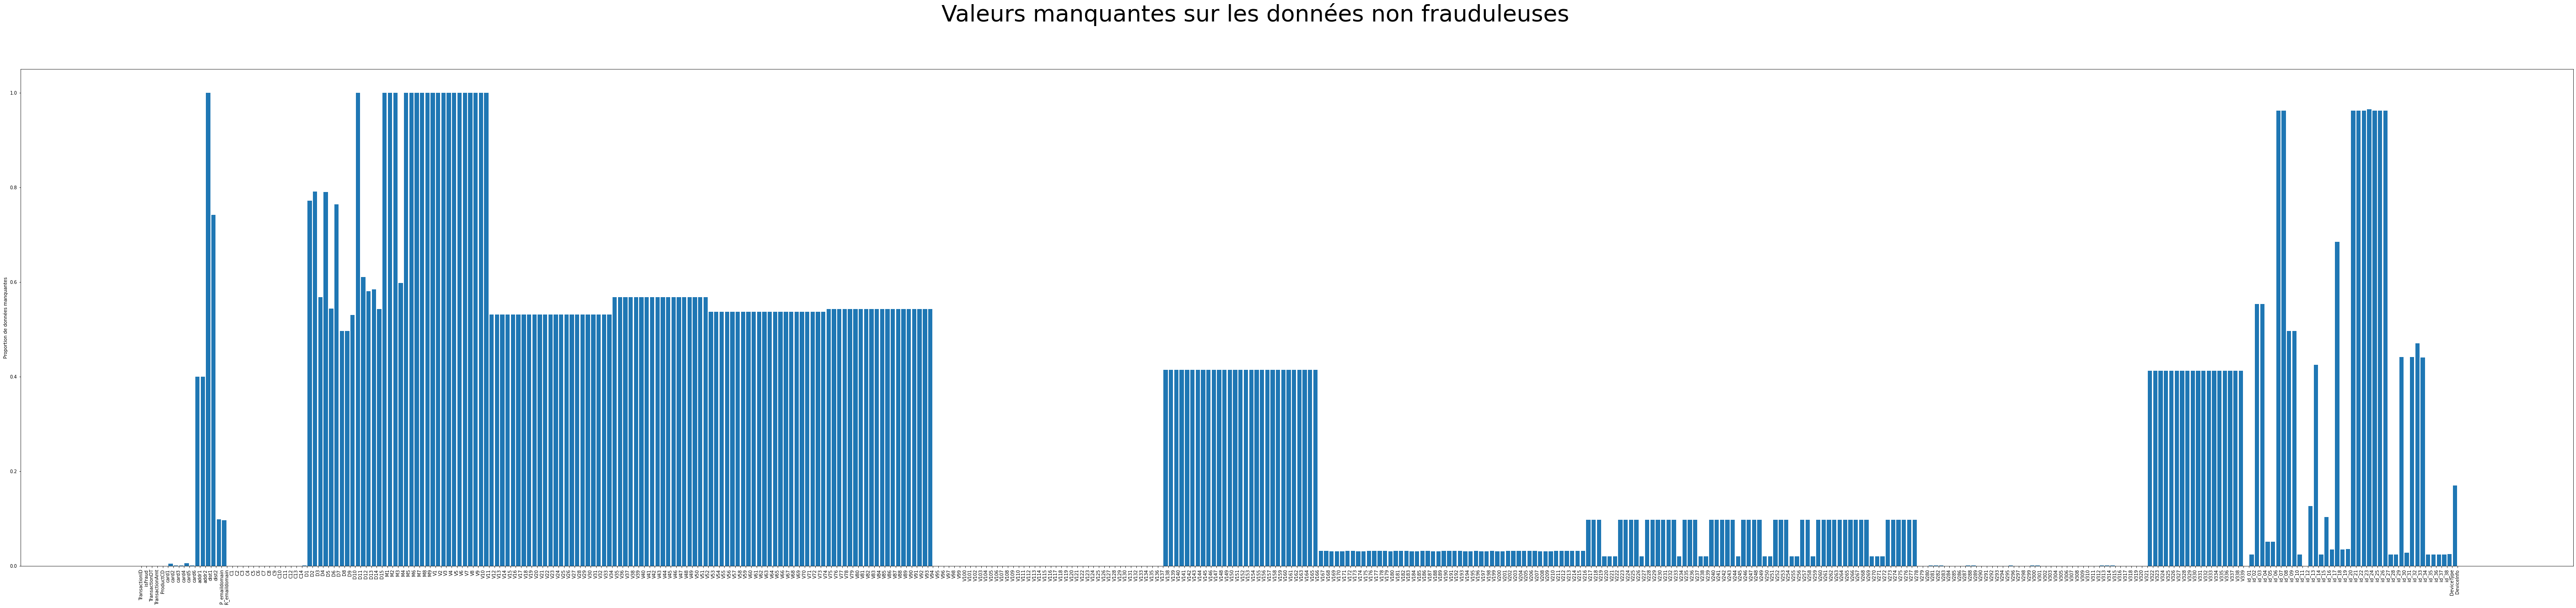

In [26]:
missing_view(train_calibrate[train_calibrate.isFraud == 0])
plt.suptitle("Valeurs manquantes sur les données non frauduleuses", fontsize=50)

De manière générale, on remarque que la représentation est pratiquement la même. On peut dès lors faire une courbe de sensibilité pour voir le nombre de variables par seuil.

**Courbe de sensibilité**

In [27]:
train_column_miss = train_calibrate.isnull().any()
print(f'Nombre de variables avec des données manquantes (apprentissage) : {train_column_miss.sum()} .')

Nombre de variables avec des données manquantes (apprentissage) : 412 .


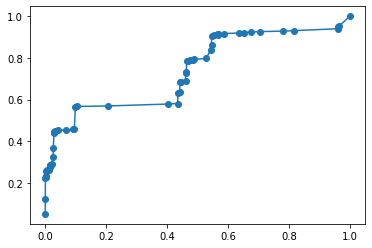

In [28]:
column_miss = train_calibrate.isnull().sum()/train_calibrate.shape[0]
my_series = pd.Series(np.sort(column_miss.values))
sensibility_graph = my_series.value_counts().reset_index().sort_values(by=['index'])
sensibility_graph[0] = np.cumsum(sensibility_graph[0]/sensibility_graph[0].sum())
plt.plot(sensibility_graph['index'], sensibility_graph[0], '-o')

On peut essayer de voir ce qui se passe à partir de 60 % de données manquantes.

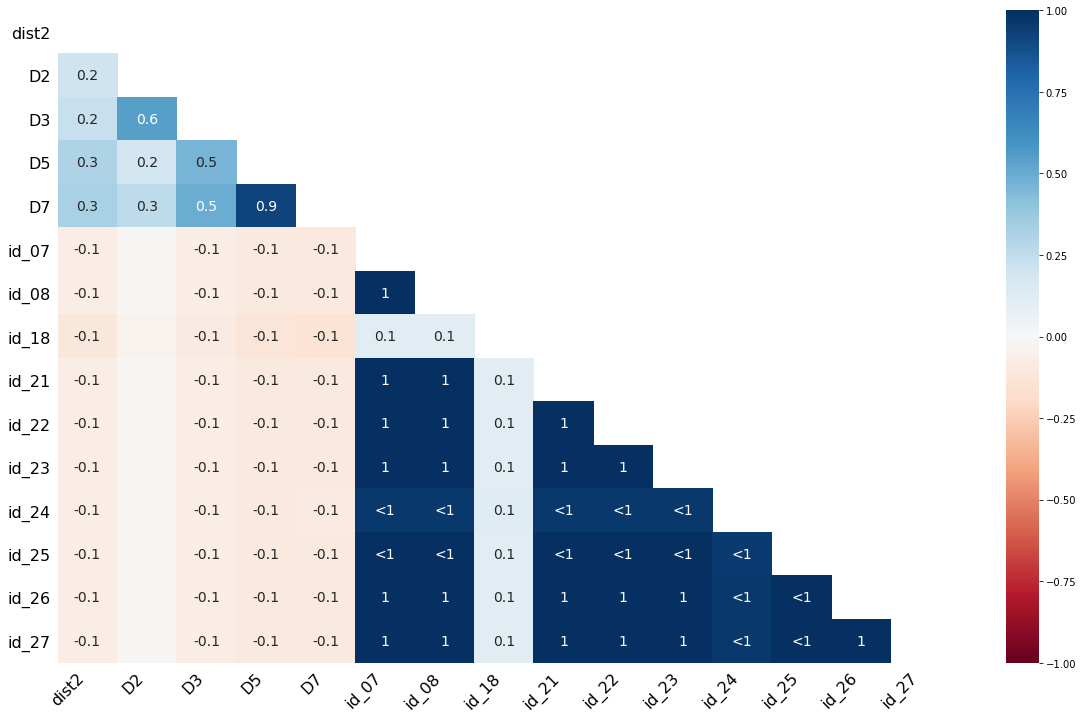

In [29]:
null_counts = train_calibrate.isnull().sum()/len(train_calibrate)
train_data_miss_60 = train_calibrate.filter(items=null_counts[null_counts>=0.6].reset_index()['index'])
msno.heatmap(train_data_miss_60)

On remarque que pour plusieurs des variables, elles prennent conjointement les valeurs manquantes. Couplé au fait que l'apparition des données manquantes est relativement indépendant du caractère frauduleux de la variable, on peut se restreindre aux variables de moins de 60% de valeurs manquantes. De plus, la courbe de sensibilité nous incite à abaisser ce taux à 20% puisqu'il n'y a pas énormément de variables entre 20 et 40%. Une analyse comparative des résultats pourra être ajoutée suivant le seuil choisi.

**Traitement des valeurs manquantes**

In [30]:
###On décide de ne retenir que les variables de moins de 20% de données manquantes et de procéder à une imputation par KNN 
train_work = train_calibrate.filter(items=null_counts[null_counts<0.2].reset_index()['index'])
train_work.shape

(22636, 246)


Valeur manquante en utilisant  Multivariate Imputation by Chained Equation (MICE) [Mice](https://www.jstatsoft.org/article/view/v045i03)

In [ ]:
"""
from impyute.imputation.cs import mice
from datetime import datetime
start_time = datetime.now()
train_imputed1=mice(train_work.select_dtypes(exclude='object').values)
end_time = datetime.now()
time_mice=end_time-start_time
"""

In [ ]:
#train_imputed1

In [31]:
from sklearn.impute import KNNImputer
tps1 = time.clock()
train_imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(train_work.select_dtypes(exclude='object'))
tps2 = time.clock()
time_treatment_var_manquant_KNN = tps2-tps1
print('Temps execution du traitement des valeurs manquantes:', tps2-tps1)

Temps execution du traitement des valeurs manquantes: 201.386711


In [32]:
train_imputed

array([[2.9870040e+06, 0.0000000e+00, 8.6506000e+04, ..., 1.6600000e+02,
        5.4200000e+02, 1.4400000e+02],
       [2.9871480e+06, 0.0000000e+00, 8.8842000e+04, ..., 1.6600000e+02,
        3.9000000e+02, 5.4900000e+02],
       [2.9872070e+06, 0.0000000e+00, 8.9828000e+04, ..., 1.6600000e+02,
        5.2900000e+02, 2.2200000e+02],
       ...,
       [3.5773640e+06, 1.0000000e+00, 1.5807516e+07, ..., 2.2500000e+02,
        2.6600000e+02, 3.1500000e+02],
       [3.5773680e+06, 1.0000000e+00, 1.5807677e+07, ..., 1.6600000e+02,
        4.9200000e+02, 2.2500000e+02],
       [3.5775260e+06, 1.0000000e+00, 1.5810876e+07, ..., 1.6600000e+02,
        3.5200000e+02, 3.3300000e+02]])

In [33]:
train_imputed = pd.DataFrame(train_imputed)
train_imputed.columns = train_work.select_dtypes(exclude='object').columns
train_imputed = pd.merge(train_imputed,train_work[np.append('TransactionID',train_work.select_dtypes('object').columns.values)],on="TransactionID",how="left")
train_imputed


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,2987004.0,0.0,86506.0,50.000,4497.0,514.0,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,70787.0,4.4,-8.2,100.0,51.8,166.0,542.0,144.0,H,mastercard,credit,gmail.com,NaN,NotFound,New,NotFound,New,NotFound,samsung browser 6.2,T,F,T,T,mobile
1,2987148.0,0.0,88842.0,30.000,14858.0,558.0,150.0,226.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,-5.0,123916.0,0.0,0.0,100.0,49.0,166.0,390.0,549.0,H,visa,debit,yahoo.com,NaN,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
2,2987207.0,0.0,89828.0,25.000,6019.0,583.0,150.0,226.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,-5.0,84798.0,4.0,0.0,100.0,49.0,166.0,529.0,222.0,H,visa,credit,yahoo.com,NaN,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
3,2987240.0,1.0,90193.0,37.098,13413.0,103.0,185.0,137.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,169947.0,3.0,0.0,100.0,45.0,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
4,2987243.0,1.0,90246.0,37.098,13413.0,103.0,185.0,137.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,222455.0,0.0,0.0,100.0,43.0,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22631,3577351.0,1.0,15807131.0,125.665,3289.0,176.0,185.0,224.0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,-20.0,190267.0,-5.0,-20.0,100.0,27.0,225.0,417.0,612.0,C,mastercard,credit,gmail.com,gmail.com,NotFound,New,NotFound,New,NotFound,chrome 66.0 for android,F,F,T,F,mobile
22632,3577354.0,1.0,15807171.0,125.665,14337.0,228.0,106.0,137.0,3.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,-25.0,229668.0,-5.0,-20.0,100.0,27.0,225.0,417.0,612.0,C,visa,debit,gmail.com,gmail.com,NotFound,Found,Found,Found,Found,chrome 66.0 for android,F,F,T,F,mobile
22633,3577364.0,1.0,15807516.0,69.964,5812.0,408.0,185.0,224.0,1.0,3.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,2.0,0.0,0.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,48.0774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0774,0.0,0.0,0.0,0.0,-5.0,183132.0,0.0,0.0,100.0,27.0,225.0,266.0,315.0,C

### **Analyse et traitement des valeurs aberrantes**

**Détection des valeurs aberrantes**

In [34]:
#detection des valeurs aberrantes
def replace_VA(df_in, col_name):
       q1 = df_in[col_name].quantile(0.25)
       q3 = df_in[col_name].quantile(0.75)
       iqr = q3-q1 #Interquartile range
       fence_low  = q1-1.5*iqr
       fence_high = q3+1.5*iqr
       for i in range(len(df_in[col_name])):
          if df_in[col_name][i]!='NaN':
            if df_in[col_name][i]< fence_low or df_in[col_name][i]>fence_high:
              df_in[col_name][i]=np.NaN

In [35]:
train_imputed['TransactionID']=train_imputed['TransactionID'].astype(int)
df=train_imputed.select_dtypes(exclude='object')
df_object=train_imputed.select_dtypes(exclude='float64')


In [36]:
#traitement des valeurs manquantes 
tps1 = time.clock()
for i in range(3,len(df.columns)):
  varc=df.columns[i]
  replace_VA(df, varc)
tps2 = time.clock()
print('Temps de remplacement des valeurs aberrantes en NaN', tps2-tps1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Temps de remplacement des valeurs aberrantes en NaN 254.36491399999994


In [37]:
#Base de données après traitement des valeurs aberrantes 
train_imputed=pd.merge(df,df_object,on="TransactionID",how="right")

In [38]:
#On utilise le KNN précedent pour traiter les NaN créés
tps1 = time.clock()
df_ok = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(df)
df_ok = pd.DataFrame(df_ok)
df_ok.columns = df.columns
tps2 = time.clock()
time_treatment_var_aberrant = tps2-tps1
print('Temps execution des valeurs aberrantes:', tps2-tps1)

Temps execution des valeurs aberrantes: 748.747029


In [39]:
#Base de données après traitement des valeurs aberrantes 
train_imputed=pd.merge(df_ok,df_object,on="TransactionID",how="right")

In [40]:
train_imputed 

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,2987004.0,0.0,86506.0,50.0000,4497.0,514.0,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,0.6,-8.2,100.0,51.8,166.0,542.0,144.0,H,mastercard,credit,gmail.com,NaN,NotFound,New,NotFound,New,NotFound,samsung browser 6.2,T,F,T,T,mobile
1,2987148.0,0.0,88842.0,30.0000,14858.0,558.0,150.0,226.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,123916.0,0.0,0.0,100.0,49.0,166.0,390.0,549.0,H,visa,debit,yahoo.com,NaN,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
2,2987207.0,0.0,89828.0,25.0000,6019.0,583.0,150.0,226.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,84798.0,0.6,0.0,100.0,49.0,166.0,529.0,222.0,H,visa,credit,yahoo.com,NaN,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
3,2987240.0,1.0,90193.0,37.0980,13413.0,103.0,185.0,137.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169947.0,0.0,0.0,100.0,45.0,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
4,2987243.0,1.0,90246.0,37.0980,13413.0,103.0,185.0,137.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,222455.0,0.0,0.0,100.0,43.0,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22631,3577351.0,1.0,15807131.0,125.6650,3289.0,176.0,185.0,224.0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-20.0,190267.0,0.2,-20.0,100.0,52.0,225.0,417.0,612.0,C,mastercard,credit,gmail.com,gmail.com,NotFound,New,NotFound,New,NotFound,chrome 66.0 for android,F,F,T,F,mobile
22632,3577354.0,1.0,15807171.0,125.6650,14337.0,228.0,106.0,137.0,3.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.0,229668.0,0.0,-20.0,100.0,52.0,225.0,417.0,612.0,C,visa,debit,gmail.com,gmail.com,NotFound,Found,Found,Found,Found,chrome 66.0 for android,F,F,T,F,mobile
22633,3577364.0,1.0,15807516.0,69.9640,5812.0,408.0,185.0,224.0,1.0,3.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,48.0774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,183132.0,0.0,0.0,100.0,52.0,225.0,266.0,315.0,C,mastercard,debit,hot

### **Traitement des variables qualitatives**

In [41]:
# Nombre de modalités par variable
train_imputed.select_dtypes('object').nunique()

ProductCD          4
card4              4
card6              3
P_emaildomain     59
R_emaildomain     60
id_12              2
id_15              3
id_16              2
id_28              2
id_29              2
id_31            109
id_35              2
id_36              2
id_37              2
id_38              2
DeviceType         2
dtype: int64

On remarque que certaines variables possèdent un nombre important de modalités, on va donc s'atteler à créer des méthodes automatiques de traitement textuel. Il s'agit de *P_emaildomain, R_emaildomain et de id_31*.

In [42]:
print(train_imputed['P_emaildomain'].value_counts(dropna=False))

gmail.com           10315
hotmail.com          4085
NaN                  2080
anonymous.com        2060
yahoo.com            1434
outlook.com           577
aol.com               456
comcast.net           212
icloud.com            177
yahoo.com.mx          108
msn.com               106
live.com.mx            95
live.com               86
outlook.es             86
sbcglobal.net          70
verizon.net            68
me.com                 66
att.net                53
mail.com               48
bellsouth.net          40
cox.net                39
hotmail.es             35
ymail.com              30
mac.com                28
protonmail.com         28
optonline.net          26
hotmail.fr             23
charter.net            21
web.de                 20
earthlink.net          18
prodigy.net.mx         17
yahoo.fr               16
gmx.de                 12
gmail                  10
hotmail.co.uk           9
yahoo.es                7
suddenlink.net          6
juno.com                5
ptd.net     

Un traitement efficace et simple serait de retirer les extensions afin de ne conserver que les noms de domaines.

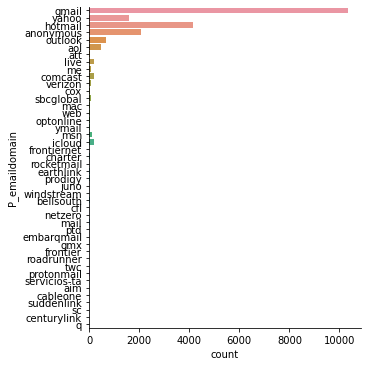

In [43]:
train_imputed['P_emaildomain'] = train_imputed['P_emaildomain'].str.split('.').str.get(0)
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

On décide aussi finalement de regrouper les modalités non significatives dans une modalité autre.

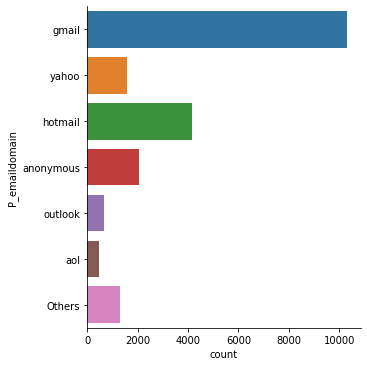

In [44]:
#On regroupe les modalités peu significatives dans autres
prop = train_imputed['P_emaildomain'].value_counts()/len(train_imputed)
train_imputed['P_emaildomain'] = np.where(train_imputed['P_emaildomain'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed['P_emaildomain'])
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

On procède à un taitement similaire pour la variable *R_emaildomain* étant donné qu'elle se présente sous le même format.

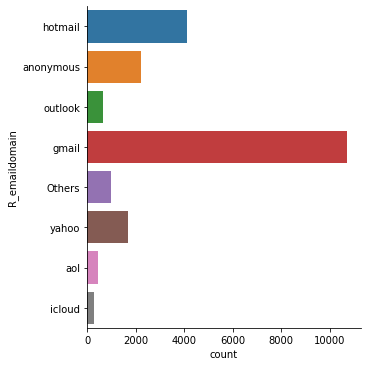

In [45]:
train_imputed['R_emaildomain'] = train_imputed['R_emaildomain'].str.split('.').str.get(0)
prop = train_imputed['R_emaildomain'].value_counts()/len(train_imputed)
train_imputed['R_emaildomain'] = np.where(train_imputed['R_emaildomain'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed['R_emaildomain'])
sns.catplot(y='R_emaildomain',kind='count',data=train_imputed)

In [46]:
#Traitement textuel de la variable sur les navigateurs
print(train_imputed['id_31'].value_counts(dropna=False))

chrome 63.0                       3292
mobile safari generic             2020
mobile safari 11.0                1931
chrome 65.0                       1229
chrome generic                    1159
chrome 64.0                       1156
chrome 63.0 for android           1077
ie 11.0 for desktop                891
safari generic                     858
chrome 62.0                        842
chrome 64.0 for android            820
chrome 66.0                        723
chrome 65.0 for android            721
chrome 66.0 for android            486
NaN                                467
edge 16.0                          450
firefox 57.0                       432
mobile safari 10.0                 356
chrome 62.0 for android            323
chrome generic for android         214
edge 15.0                          192
firefox                            184
firefox 59.0                       174
samsung browser 6.2                165
firefox 58.0                       140
chrome 61.0 for android  

En ce qui concerne le navigateur utiliser, on peut noter que l'existence de différentes versions entrainent l'existence de plusieurs modalités qui sont en réalité relatives à la même entité. On décide donc d'écrire un algorithme pour l'identification de similarité syntaxique et la labélisation.

Dans un premier temps, il s'agit d'identifier les similarités. Pour ce faire, on utilise la théorie des *ngrams* du *NLP (Natural Langage Processing)*. En particulier, vu le nombre peu important de mots par observations, on fera un **1gram**. On calcul alors un coefficient de ressemblance entre les modalités et on réalise un heatmap pour la visualisation. Enfin, on passe par une recherche sémantique des termes récurrents pour donner des labels aux modalités qui sont jugées similaires.

In [47]:
import re

def ngram(sentence, len_gram):
  """
    Fonction for splitting sentences into d-grammes
  """
  sentence = sentence.strip()
  sentence_split = re.split(r'[/\-,\s]\s*', sentence)
  words = [] 
  if len_gram >= len(sentence.split()) :
    sent_len = 1
  else :
    sent_len = len(sentence.split()) - len_gram +1
  for i in range(sent_len):
      words.append(sentence.split()[i:i+len_gram]) 
  return words

def diff_ngram(sent_a, sent_b, len_gram):
  """
    Fonction to evaluate correspondance between sentences
  """
  a = ngram(sent_a, len_gram)
  b = ngram(sent_b, len_gram) 
  cnt = 0 
  for i in a:
      for j in b:
          if i == j:
              cnt += 1
  return cnt/len(a)

def calculate_similarities(sentences):
  matrix_comparison = np.zeros((len(sentences), len(sentences)))
  for i in range(len(sentences)):
    for j in range(len(sentences)):
      matrix_comparison[i][j] = diff_ngram(sentences[i], sentences[j], 1)
  mat = pd.DataFrame(matrix_comparison).set_index(sentences)
  mat.columns = sentences
  return mat

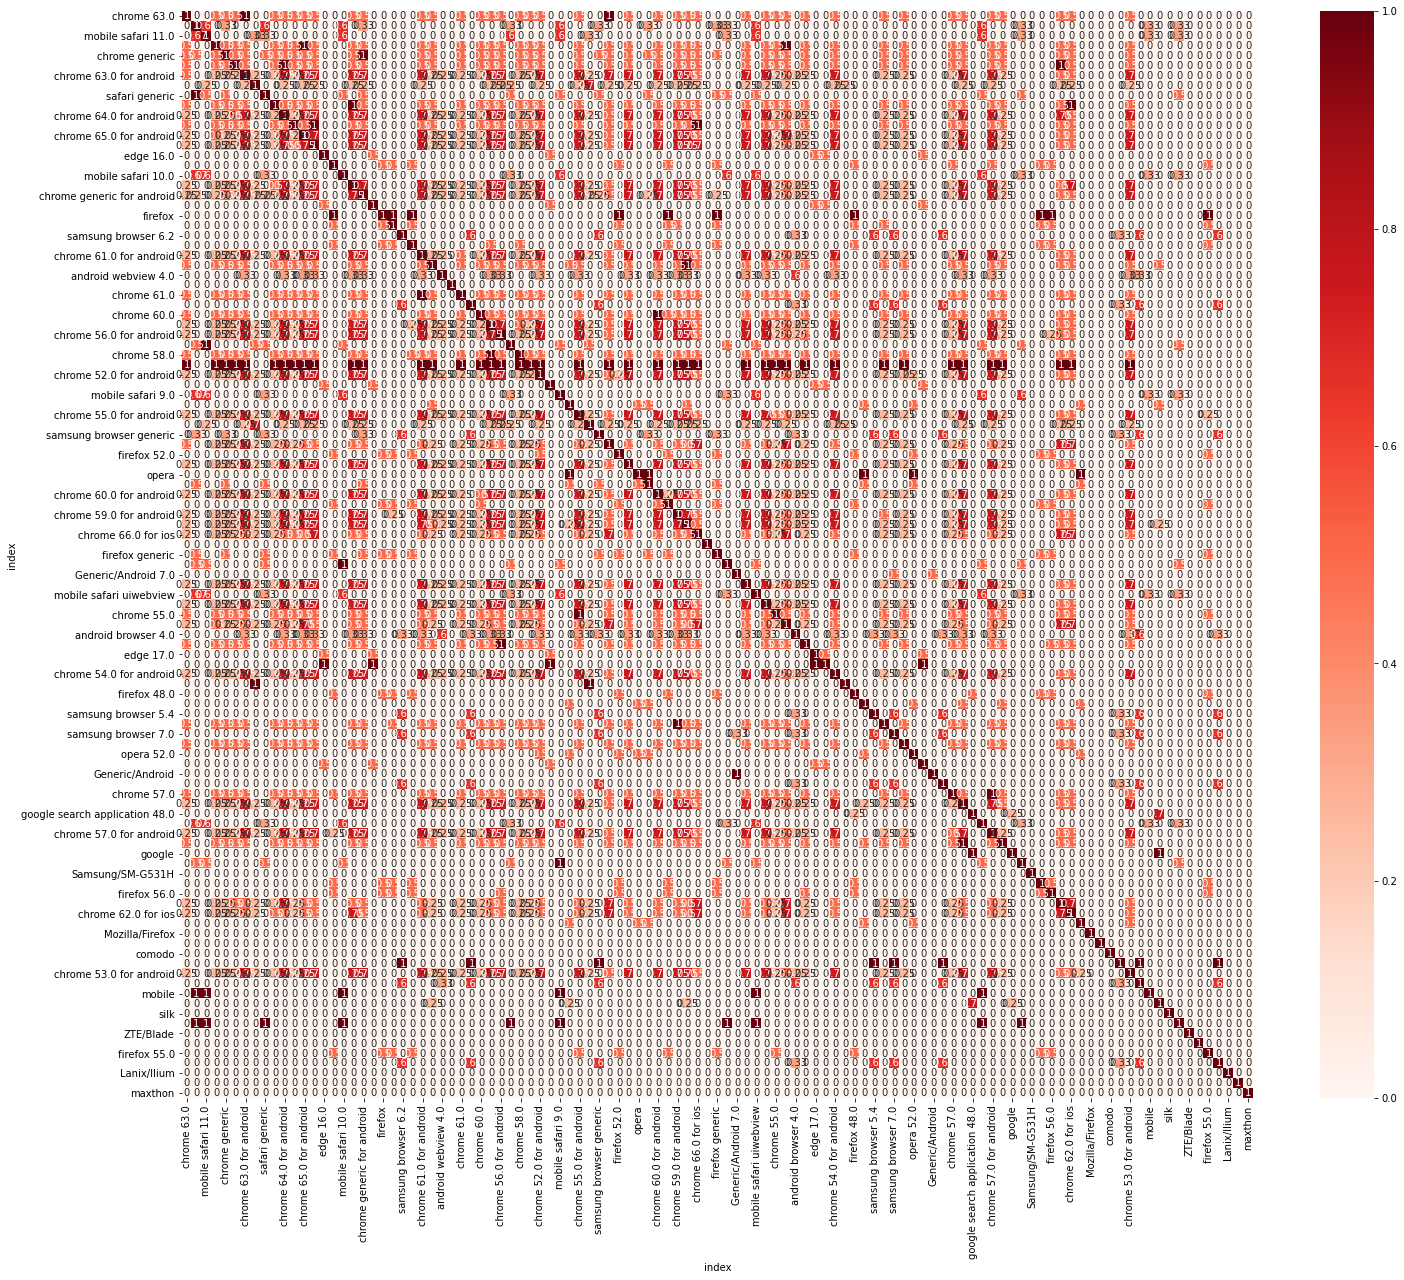

In [48]:
values = train_imputed['id_31'].value_counts().reset_index()['index']
mat = calculate_similarities(values)
plt.figure(figsize=(24,20))
sns.heatmap(mat, annot=True, cmap=plt.cm.Reds)
plt.show()

In [49]:
#Select the max per column
### First we replace on the diagonal the 1 value
i = 0
for var in mat.columns:
  mat[var][i] = 0
  i += 1
mod_list = list()
for var in mat.columns:
  tmp = mat[var][mat[var]>=0.75].reset_index()['index']
  tmp[len(tmp)] = var
  mod_list.append(np.array(tmp))

In [50]:
def common_words(text1, text2) :
  text1_words = text1.strip().split()
  text2_words = text2.strip().split()
  common = set(text1_words).intersection( set(text2_words) )
  text = ' '.join(common).strip()
  return text

In [51]:
prev_value = []
new_value = []

for elt in mod_list :
  if len(elt) > 1 :
    common_text = elt[0]
    for i in range(1,len(elt)) :
      common_text = common_words(common_text, elt[i])
    if common_text.strip() == "" :
      common_text = elt[-1]
    for val in elt :
      prev_value.append(val)
      new_value.append(common_text)

In [52]:
corr_mat = pd.DataFrame(prev_value,new_value).reset_index()
corr_mat.columns = ["New", "Prev"]
corr_mat = corr_mat.drop_duplicates('Prev')

In [53]:
train_imputed_b = pd.merge(train_imputed,corr_mat,how = 'left', left_on='id_31', right_on='Prev')
train_imputed_b['id_31'] = np.where(train_imputed_b['New'].isnull(),train_imputed_b['id_31'],train_imputed_b['New'])
train_imputed_b = train_imputed_b.drop(["New","Prev"], axis= 1)

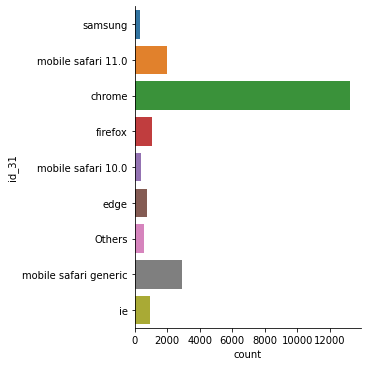

In [54]:
prop = train_imputed_b['id_31'].value_counts()/len(train_imputed_b)
train_imputed_b['id_31'] = np.where(train_imputed_b['id_31'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed_b['id_31'])
sns.catplot(y='id_31',kind='count',data=train_imputed_b)

In [55]:
#On voit le nombre de modalités par variable
train_imputed_b.select_dtypes('object').nunique()

ProductCD        4
card4            4
card6            3
P_emaildomain    7
R_emaildomain    8
id_12            2
id_15            3
id_16            2
id_28            2
id_29            2
id_31            9
id_35            2
id_36            2
id_37            2
id_38            2
DeviceType       2
dtype: int64

On se retrouve finalement avec un nombre de modalités acceptables pour les variables qualitatives.

Ensuite, afin que les algorithmes puissent traiter convenablement les variables qualitatives, on créé des variables binaires pur chacune des modalités.

In [56]:
#On met les variables categorielles dans un type exploitable
train_use = train_imputed_b.copy()
quali_col = train_imputed_b.select_dtypes('object').columns
for var in quali_col :
  train_imputed_b[var] = train_imputed_b[var].astype('category')

train_quant = train_imputed_b.drop(quali_col,axis=1)
train_imputed_b = pd.merge(train_quant,pd.get_dummies(train_imputed_b[quali_col]),right_index=True,left_index=True)

## Modelisation

In [ ]:
warnings.filterwarnings('ignore')

On commence par convertir les bases de travail au format **dask** pour permettre des traitements distribués


On compare les temps d'execution dans le modèle logistique pour valider l'utilisation du format dask

In [57]:
Y_train=train_imputed_b['isFraud'].astype('int')
X_train=train_imputed_b.drop('isFraud',axis=1)
scaler=preprocessing.StandardScaler()
X_train_st=scaler.fit_transform(X_train)

In [58]:
## Execution sur pandas
model = LogisticRegression()
%time model.fit(X_train_st, Y_train)

CPU times: user 2.66 s, sys: 488 ms, total: 3.15 s
Wall time: 1.72 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [59]:
## Execution avec dask
with joblib.parallel_backend('dask'):
  model = LogisticRegression()
  %time model.fit(X_train_st, Y_train)

CPU times: user 205 ms, sys: 60.8 ms, total: 266 ms
Wall time: 2.82 s


Comme on peut le voir les temps de traitements au niveau du CPU sont bien plus faible avec le traitement distribué. On adopte alors cette approche dans la suite.

### **Logistic Regression (Features Selection and execution)**

Bien qu'elle soit appelée régression, la régression logistique est en fait une technique de classification supervisée largement utilisée. La régression logistique et ses extensions, comme la régression logistique multinomiale, nous permettent de prédire la probabilité qu'une observation soit d'une certaine classe en utilisant une approche simple et bien comprise.

La Logistic Regression a un hyperparameter $C$ :  regularization parameter

\begin{equation}
        \Large p_+ = P\left(y_i = 1 \mid \textbf{x}_\text{i}, \textbf{w}\right)
\end{equation}
[Logistic Regression](https://mlcourse.ai/articles/topic4-part2-logit/)

[ regularization parameter](https://mlcourse.ai/articles/topic4-part3-regularization/)

**First execution of Logistic Regression**

In [ ]:
cv_estimator=LogisticRegression(C=1,random_state=42)

In [ ]:
with joblib.parallel_backend('dask'):
  cv_estimator.fit(X_train_st, Y_train)

In [ ]:
with joblib.parallel_backend('dask'):
  cv_scores = cross_val_score(cv_estimator, X_train_st, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

In [ ]:
importance = cv_estimator.coef_[0]
imp=np.zeros(len(importance))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X_train.columns),ax=ax)

In [ ]:
#Courbe pour l'évolution du cv_score en fonction du paramètre C
import time

vscores=np.zeros(100)
vtime=np.zeros(100)
for i in range(100):
  tps1 = time.clock()
  with joblib.parallel_backend('dask'):
    logit=LogisticRegression(C=i+1,random_state=42)
    cv_scores = cross_val_score(logit, X_train_st, Y_train, cv=5, scoring='roc_auc')
  tps2 = time.clock()
  vscores[i]=cv_scores.mean()
  vtime[i]=tps2-tps1

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(131)
plt.plot(vscores)
plt.ylabel('Score du modèle')

plt.subplot(132)
plt.plot(vtime)
plt.ylabel('Temps execution')

plt.subplot(133)
plt.scatter(vscores,vtime)
plt.ylabel('Temps execution')
plt.xlabel('Score du modèle')
plt.show()


**Recursive Feature Elimination with Cross Validation**

In [ ]:
cv_estimator=LogisticRegression(C=2,random_state=42)
with joblib.parallel_backend('dask'):
  cv_selector = RFECV(cv_estimator,cv= 5, step=1,scoring="f1")
  cv_selector = cv_selector.fit(X_train_st, Y_train)
rfecv_mask = cv_selector.get_support() #list of booleans

In [ ]:
rfecv_features = [] 
for bool, feature in zip(rfecv_mask, X_train.columns):
 if bool:
   rfecv_features.append(feature)
print("Optimal number of features :", cv_selector.n_features_)
print("Best features :", rfecv_features)

In [ ]:
pp=[]
for i in range(len(cv_selector.support_)):
  if cv_selector.support_[i]==False:
    pp.append(list(X_train.columns)[i])
X_train1=X_train.drop(pp,axis=1)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X_train1)
with joblib.parallel_backend('dask'):
  cv_estimator.fit(X_train_st1, Y_train)
  cv_scores = cross_val_score(cv_estimator, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score augmente

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(cv_selector.grid_scores_) + 1), cv_selector.grid_scores_, color='#303F9F', linewidth=3)
plt.axes.xaxis.set_ticks(range(1, len(cv_selector.grid_scores_) + 1))
plt.axes.xaxis.set_ticklabels(range(1, len(cv_selector.grid_scores_) + 1), rotation = 90, color = 'red', fontsize = 8, style = 'italic', verticalalignment = 'center')
plt.axes.xaxis.grid(True, which = 'both', color = 'gray', zorder = 0)
plt.show()

**Model with best features from RFECV**

In [ ]:
X_train1= X_train.filter(rfecv_features,axis=1)
X_train_st1=scaler.fit_transform(X_train1)
with joblib.parallel_backend('dask'):
  cv_estimator.fit(X_train_st1, Y_train)
  cv_scores = cross_val_score(cv_estimator, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score reste le meme

In [ ]:
## Confusion matrix 
from sklearn import metrics
with joblib.parallel_backend('dask'):
  Y_pred=cv_estimator.predict(X_train1)
  cnf_matrix = metrics.confusion_matrix(Y_train,Y_pred)
cnf_matrix

In [ ]:

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(Y_train,Y_pred))
print("Precision:",metrics.precision_score(Y_train,Y_pred))
print("Recall:",metrics.recall_score(Y_train,Y_pred))

In [ ]:
# ROC Curve
with joblib.parallel_backend('dask'):
  Y_pred_proba = cv_estimator.predict_proba(X_train1)[::,1]
  fpr, tpr, _ = metrics.roc_curve(Y_train,  Y_pred_proba)
  auc = metrics.roc_auc_score(Y_train, Y_pred_proba)
plt.plot(fpr,tpr,label="Logit model, AUC="+str(auc))
plt.legend(loc=4)
plt.show()

### **Random Forest (Features Selection and execution)**

**SVM**

De meme on commence par convertir les bases de travail au format dask pour permettre des traitements distribués

On compare les temps d'execution dans le modèle SVM pour valider l'utilisation du format dask

In [63]:
## Execution sur pandas
from sklearn.svm import SVC 
model = SVC()
%time model.fit(X_train_st, Y_train)

CPU times: user 4min 10s, sys: 3.06 s, total: 4min 13s
Wall time: 6min 18s


SVC()

In [64]:
## Execution avec dask
with joblib.parallel_backend('dask'):
  model = SVC()
  %time model.fit(X_train_st, Y_train)

Task was destroyed but it is pending!
task: <Task pending coro=<DaskDistributedBackend._collect() running at /usr/local/lib/python3.6/dist-packages/joblib/_dask.py:198> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f24cce21df8>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /usr/local/lib/python3.6/dist-packages/tornado/ioloop.py:719]>
Task was destroyed but it is pending!
task: <Task pending coro=<DaskDistributedBackend._collect() running at /usr/local/lib/python3.6/dist-packages/joblib/_dask.py:198> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f24b9df3828>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /usr/local/lib/python3.6/dist-packages/tornado/ioloop.py:719]>


CPU times: user 4min 11s, sys: 2.96 s, total: 4min 14s
Wall time: 6min 22s


Pour comprendre les SVM, nous devons comprendre les hyperplans. Un hyperplan est un sous-espace à n - 1 dans un espace à n dimensions. Bien que cela semble com‐plex, c'est en fait assez simple. Par exemple, si nous voulions diviser un espace à deux dimensions, nous utiliserions un hyperplan à une dimension (c'est-à-dire une ligne). Si nous voulions
pour diviser un espace tridimensionnel, nous utiliserions un hyperplan bidimensionnel (c.-à-d.
un morceau de papier plat ou un drap de lit). Un hyperplan est simplement une généralisation de cette con‐
cept en n dimensions.
Les svm classifient les données en trouvant l'hyperplan qui maximise le
marge entre les classes dans les données d'entraînement. Dans un exemple bidimensionnel avec
deux classes, nous pouvons considérer un hyperplan comme la «bande» droite la plus large (c'est-à-dire la ligne avec
marges) qui sépare les deux classes.

Pour les classes qui sont lineairement inséparable, on utilise des Kernel. Ici on utilise le kernel $rbf$  qui a pour [formule](https://en.wikipedia.org/wiki/Radial_basis_function_kernel):

image.png

ou gamma ici est un hyperparameter

svm tuning

In [65]:
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV   
# defining parameter range 
param_grid = {'C': [0.1, 100],  
              'gamma': [1, 0.01], 
              'kernel': ['rbf']}  
tip1=time.clock()
with joblib.parallel_backend('dask'):  
  grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  grid.fit(X_train, Y_train) 
tip2=time.clock() 
# fitting the model for grid search 
print(grid.best_params_)
print("le temps de l'éxcution de gridSearch est:",tip2-tip1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 48.4min finished


{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
le temps de l'éxcution de gridSearch est: 491.720497


In [ ]:
start_time = time.clock()
Support_vector=SVC(C=0.1,gamma=1,kernel='rbf')
cv_scores = cross_val_score(Support_vector, X_train, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()
end_time = time.clock()
time_SVM=end_time-start_time

**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
start_time=datetime.now()
decision_tree_gini=DecisionTreeClassifier(criterion='gini',random_state=42)
cv_scores = cross_val_score(decision_tree_gini, X_train1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()
end_time=datetime.now()
time_decision_tree=end_time-start_time

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
cv_estimator = RandomForestClassifier(random_state =42)
cv_estimator.fit(X_train, Y_train)
cv_selector = RFECV(cv_estimator,cv= 5, step=1,scoring="accuracy")
cv_selector = cv_selector.fit(X_train, Y_train)
rfecv_mask = cv_selector.get_support() #list of booleans
rfecv_features = [] 
for bool, feature in zip(rfecv_mask, X_train.columns):
 if bool:
 rfecv_features.append(feature)
print("Optimal number of features :", cv_selector.n_features_)
print("Best features :", rfecv_features)
n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
X_train_rf=X_train.filter(rfecv_features,axis=1)
start_time=datetime.now()
randomforest=RandomForestClassifier(random_state=42,n_jobs=-1,criterion="gini")
cv_scores = cross_val_score(randomforest, X_train_rf, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()
end_time=datetime.now()
time_random_forest=end_time-start_time

**Boosting**

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_